In [61]:
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate, BasePromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain.output_parsers.xml import XMLOutputParser
from pydantic import BaseModel, Field

## Text Loaders and Splitters
from langchain.document_loaders import PyPDFLoader, WebBaseLoader, TextLoader, JSONLoader, UnstructuredXMLLoader, ArxivLoader, WikipediaLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter, RecursiveJsonSplitter
from langchain_core.documents import Document
import bs4
import requests
from langchain_text_splitters import RecursiveCharacterTextSplitter 

## Embeddings
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
# from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# import faiss
from langchain_community.vectorstores import FAISS, Chroma
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain import hub
# import pprintr
from langchain_core.runnables import RunnablePassthrough

from langchain.agents import tool
from langchain_community.tools import WikipediaQueryRun, YouTubeSearchTool
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools import DuckDuckGoSearchRun


from langgraph.graph import StateGraph, END, MessagesState, START
from IPython.display import Image, display
import operator
from typing_extensions import TypedDict
from typing import Annotated, Sequence
# from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

from langgraph.prebuilt import ToolNode, tools_condition
import yfinance as yf

from langchain.tools.retriever import create_retriever_tool

from typing import Literal
#we use it for type of hinting


## Define model and embeddings

In [2]:
model = ChatOpenAI(model="gpt-4o", temperature=0.0, max_retries=3)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large", chunk_size=1)

## Data Ingestion pipeline

#### Web based loader

In [3]:
urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

web_docs = [WebBaseLoader(url).load() for url in urls]
web_docs

[[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final res

In [4]:
docs = [i for doc in web_docs for i in doc]
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [5]:
# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25)
texts = text_splitter.split_documents(docs)
texts

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [6]:
db = Chroma.from_documents(texts, embeddings, collection_name="agentic-rag-pipeline-db")
retriever=db.as_retriever()


In [8]:
retriever.invoke("What is Agentic AI?")

[Document(metadata={'title': "LLM Powered Autonomous Agents | Lil'Log", 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [9]:
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="agentic_rag_pipeline_retriever",
    description="A tool to retrieve information from the Agentic RAG pipeline database.",
)

## BUILD NODES

In [10]:
tools = [retriever_tool]

retriever_node = ToolNode(tools)

In [11]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [24]:
class GradeDocs(BaseModel):
    score: str = Field(default="0.0", description="Returns Yes if docs are relevant, No otherwise.")

In [26]:
llm_with_tools = model.bind_tools(tools)

In [52]:
def supervisor(state: AgentState) -> AgentState:
    """Supervisor function to check if the conversation is done."""
    print("--- Supervisor function called ---")
    messages = state["messages"]
    question = messages[-1].content

    print(f"Question: {question}")

    response = llm_with_tools.invoke(question)

    print(f"Response: {response}")
    return {"messages": [response]}


def grade_documents(state: AgentState) -> Literal["generator", "rewriter"]:
    """Grader function to evaluate the quality of the messages in the state."""
    print("--- Grader function called ---")

    # New way to link Pydantic models with LangGraph
    llm_with_structure_op = model.with_structured_output(GradeDocs)

    messages = state["messages"]
    question = messages[0].content
    docs = messages[-1].content

    prompt = PromptTemplate(
        template="Grade the relevance of the following documents to the question: {question}\n\nDocuments:\n{context}\n\nScore (Yes/No):",
        input_variables=["question", "context"]
    )

    chain = prompt | llm_with_structure_op

    response = chain.invoke({
        "question": question,
        "context": docs
    })

    if response.score.lower() == "yes":
        print("Documents are relevant. Proceeding to generator.")
        return "generator"
    else:
        print("Documents are not relevant. Proceeding to rewriter.")
        return "rewriter"


def rewriter(state: AgentState) -> AgentState:
    """Rewrite the messages in the state."""
    print("--- Rewriter function called ---")
    ## For Query Rewriting - Need question and Prompt

    messages = state["messages"]
    question = messages[0].content

    prompt = PromptTemplate(
        template="Rewrite the question to make it more specific: {question}",
        input_variables=["question"]
    )

    chain = prompt | model

    response = chain.invoke({"question": question})

    print(f"Rewritten Question: {response.content}")

    return {"messages": [response]}

def generator(state: AgentState) -> AgentState:
    """Generate a response based on the messages in the state."""
    print("--- Generator function called ---")

    messages = state["messages"]
    question = messages[0].content
    docs = messages[-1].content

    prompt = PromptTemplate(
        template="""
            You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
            Question: {question} 
            Context: {context} 
        """,
        input_variables=["question", "context"]
    )

    chain = prompt | model

    response = chain.invoke({
        "question": question,
        "context": docs
    })

    print(f"Generated Response: {response.content}")
    return {"messages": [response]}

## Define graph and workflow

In [53]:
workflow = StateGraph(AgentState)

workflow.add_node("supervisor", supervisor)
workflow.add_node("tools", retriever_node)
workflow.add_node("rewriter", rewriter)
workflow.add_node("generator", generator)

workflow.add_edge(START, "supervisor")
workflow.add_conditional_edges("supervisor", tools_condition)
workflow.add_conditional_edges("tools", grade_documents, {
    "rewriter": "rewriter",
    "generator": "generator"
})

workflow.add_edge("generator", END)
workflow.add_edge("rewriter", "supervisor")

In [54]:
app = workflow.compile()

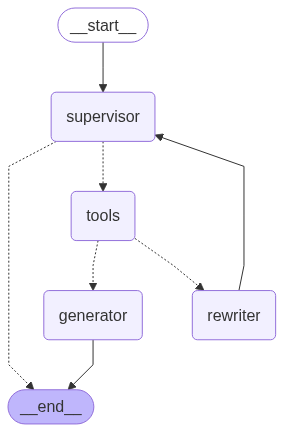

In [55]:
display(Image(app.get_graph().draw_mermaid_png()))

In [56]:
response = app.invoke({"messages": [HumanMessage(content="What is Agentic AI?")]})
response

--- Supervisor function called ---
Question: What is Agentic AI?
Response: content='' additional_kwargs={'tool_calls': [{'id': 'call_NWbVbC7h8k9EXSIpLiayIJrk', 'function': {'arguments': '{"query":"Agentic AI"}', 'name': 'agentic_rag_pipeline_retriever'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 72, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff25b2783a', 'id': 'chatcmpl-C1jWn3VzqlWtm6FyZSZFxewLxSwHF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--e6ba6f85-4060-441b-8e21-19ba6e00cf1c-0' tool_calls=[{'name': 'agentic_rag_pipeline_retriever', 'args': {'query': 'Agentic AI'}, 'id': 'call_NWbVbC7h8k9EXSIpLiayIJrk', 'type': 'tool_call'}] usa

{'messages': [HumanMessage(content='What is Agentic AI?', additional_kwargs={}, response_metadata={}, id='60842bec-1dcb-419d-bcfb-21d535f4d4e1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NWbVbC7h8k9EXSIpLiayIJrk', 'function': {'arguments': '{"query":"Agentic AI"}', 'name': 'agentic_rag_pipeline_retriever'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 72, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff25b2783a', 'id': 'chatcmpl-C1jWn3VzqlWtm6FyZSZFxewLxSwHF', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e6ba6f85-4060-441b-8e21-19ba6e00cf1c-0', tool_calls=[{'name': 'agentic_rag_pipeline_retriever', 'args': {'

In [57]:
response["messages"][-1].content

'Agentic AI refers to AI systems, particularly those powered by large language models (LLMs), that act as autonomous agents capable of solving general problems. These systems can perform tasks such as generating content, interacting in simulated environments, and using external tools or APIs to access additional information. Examples include AutoGPT, GPT-Engineer, and BabyAGI, which demonstrate the potential of LLMs as core controllers in agent systems.'

In [58]:
response = app.invoke({"messages":["what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?"]})
response["messages"][-1].content

--- Supervisor function called ---
Question: what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?
Response: content='' additional_kwargs={'tool_calls': [{'id': 'call_4oG08oCXCY8Dp7muL54yArxz', 'function': {'arguments': '{"query": "LLM Powered Autonomous Agents"}', 'name': 'agentic_rag_pipeline_retriever'}, 'type': 'function'}, {'id': 'call_yf7rYYjM2pOH8poxRCYafKrr', 'function': {'arguments': '{"query": "planning and reflection in autonomous agents"}', 'name': 'agentic_rag_pipeline_retriever'}, 'type': 'function'}, {'id': 'call_KMrmxYqfacxhQXpmRPNp5kU9', 'function': {'arguments': '{"query": "prompt engineering in autonomous agents"}', 'name': 'agentic_rag_pipeline_retriever'}, 'type': 'function'}, {'id': 'call_6fvvKnd8sRGsGrSZrEB36VIE', 'function': {'arguments': '{"query": "Langchain in autonomous agents"}', 'name': 'agentic_rag_pipeline_retriever'}, 'type': 'function'}], 'refusal': None} response_m

"LLM-powered autonomous agents use large language models as their core controllers to perform tasks by interacting with external APIs and accessing additional information beyond their pre-trained knowledge. Planning involves the agent determining the sequence of actions needed to achieve a goal, while reflection allows the agent to evaluate and adjust its actions based on feedback. Prompt engineering is crucial in guiding the agent's responses and actions by crafting specific inputs that align with the desired outcomes, as seen in frameworks like Langchain."

In [59]:
response = app.invoke({"messages":["hi how are you"]})
response["messages"][-1].content

--- Supervisor function called ---
Question: hi how are you
Response: content="Hello! I'm just a computer program, so I don't have feelings, but I'm here to help you. How can I assist you today?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 70, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff25b2783a', 'id': 'chatcmpl-C1jYMoNqEXHgHsZDylpXCkNc9mCKj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--0564dc4e-9d10-465e-a9bf-6cce754f1eb2-0' usage_metadata={'input_tokens': 70, 'output_tokens': 29, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


"Hello! I'm just a computer program, so I don't have feelings, but I'm here to help you. How can I assist you today?"

In [60]:
question="can you explain me what is a task decomposition and why Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks?"
response = app.invoke({"messages":[question]})
response["messages"][-1].content

--- Supervisor function called ---
Question: can you explain me what is a task decomposition and why Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks?
Response: content='' additional_kwargs={'tool_calls': [{'id': 'call_0R2hiSTcohyJ9rdjKu6276Ht', 'function': {'arguments': '{"query": "task decomposition"}', 'name': 'agentic_rag_pipeline_retriever'}, 'type': 'function'}, {'id': 'call_d0tDb5Sw7bkZoERxMki6nOsn', 'function': {'arguments': '{"query": "Chain of Thought (CoT) prompting technique"}', 'name': 'agentic_rag_pipeline_retriever'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 106, 'total_tokens': 171, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-0

'Task decomposition involves breaking down complex tasks into smaller, more manageable steps. Chain of Thought (CoT) prompting enhances model performance on complex tasks by instructing the model to "think step by step," allowing it to utilize more computation at test time and providing insight into the model\'s reasoning process. This approach is particularly beneficial for large models and complex reasoning tasks.'